In [81]:
## ALarsen working notebook

In [82]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [83]:
!pwd

/Users/adamlarsen/Documents/Flatiron/phase-4/Project_4/TimeSeriesP4


In [84]:
df = pd.read_csv('DJIA_equities/CSCO_2006-01-01_to_2018-01-01.csv')

In [85]:
df.head(15)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
1,2006-01-04,17.48,17.93,17.46,17.85,80409776,CSCO
2,2006-01-05,17.94,18.48,17.93,18.35,118588943,CSCO
3,2006-01-06,18.51,18.88,18.47,18.77,122450979,CSCO
4,2006-01-09,18.97,19.11,18.92,19.06,78604868,CSCO
5,2006-01-10,18.87,19.15,18.78,18.97,73839465,CSCO
6,2006-01-11,18.98,19.43,18.94,19.40,73964864,CSCO
7,2006-01-12,19.27,19.35,19.08,19.20,59581203,CSCO
8,2006-01-13,19.13,19.33,18.89,18.92,52389265,CSCO
9,2006-01-17,18.70,18.78,18.47,18.68,53133127,CSCO


In [86]:
df.info()

# Looks like we need to convert the date column which is currently an object
# into a datetime object and then make that our index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [87]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.info()

# Now lets try and make this our index before looking at our columns and what we should drop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [88]:
df.set_index('Date', inplace=True)
df

# Looks like index is now set to a date time object, lets drop open, high, low, volume and name
# so that we're only left with close and the day. 

# I think we'll want to resample this data later adding open to the morning price however we'll begin
# modeling now and revisit after results.

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
2006-01-04,17.48,17.93,17.46,17.85,80409776,CSCO
2006-01-05,17.94,18.48,17.93,18.35,118588943,CSCO
2006-01-06,18.51,18.88,18.47,18.77,122450979,CSCO
2006-01-09,18.97,19.11,18.92,19.06,78604868,CSCO
...,...,...,...,...,...,...
2017-12-22,38.52,38.74,38.47,38.55,11441622,CSCO
2017-12-26,38.55,38.68,38.36,38.48,8186082,CSCO
2017-12-27,38.54,38.65,38.45,38.56,10543034,CSCO


In [96]:
df = pd.Series(df['Close'], index=df.index)

AttributeError: 'Series' object has no attribute 'info'

Date
2006-01-03    17.45
2006-01-04    17.85
2006-01-05    18.35
2006-01-06    18.77
2006-01-09    19.06
Name: Close, dtype: float64


<AxesSubplot:xlabel='Date'>

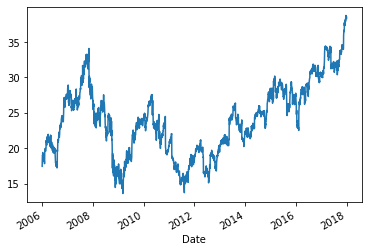

In [97]:
print(df.head())

df.plot()

# This should look like a pandas series, which it does. Let's check how this looks on a graph.

In [115]:
## Let's look at the Dickey-Fuller results to see how stationary it is. This doesn't
## look stationary at all however let's see how this looks.

def dickey(df_df):
    results = adfuller(df_df)

    p_value = results[4]['5%']

    print(f' The test statistic is: {results[0]}')
    print(f' The p-value of 5% is: {p_value}')
    return


In [116]:
log_price = np.log(df)
log_price

df_log = pd.Series(log_price, index=df.index)
df_log

Date
2006-01-03    2.859340
2006-01-04    2.882004
2006-01-05    2.909630
2006-01-06    2.932260
2006-01-09    2.947592
                ...   
2017-12-22    3.651956
2017-12-26    3.650139
2017-12-27    3.652215
2017-12-28    3.652993
2017-12-29    3.645450
Name: Close, Length: 3019, dtype: float64

 The test statistic is: -1.272011480362929
 The p-value of 5% is: -2.862498789206885


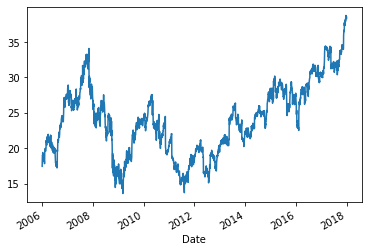

In [122]:
dickey(df)
df.plot();

 The test statistic is: -1.7414771768740476
 The p-value of 5% is: -2.862498789206885


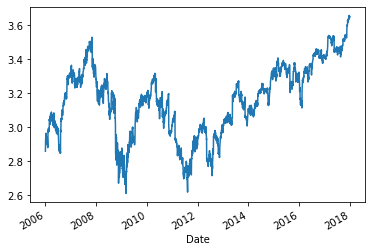

In [121]:
dickey(df_log)
df_log.plot();

Certainly getting closer however still not happy with the results given that it is not considered stationary. Let's try taking the square root of the price and see if that helps in any way shape or form.

 The test statistic is: -1.5121845155059073
 The p-value of 5% is: -2.862498789206885


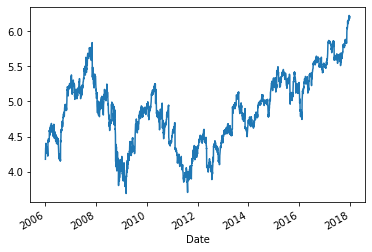

In [124]:
sqrt_price = np.sqrt(df)
df_sqrt = pd.Series(sqrt_price, index=df.index)
dickey(df_sqrt)
df_sqrt.plot();


The square root didn't seem to help all given that the test statistic came back lower than the log transformation. I also think it's important to note here that it doesn't seem like any exponential growth so as expected, these functions shouldn't have improved it much.

Let's try looking at the rolling mean and then seeing how much that helps our model.

 The test statistic is: -40.88276561608769
 The p-value of 5% is: -2.862498789206885
 The test statistic is: -23.903455783189777
 The p-value of 5% is: -2.862500063122179
 The test statistic is: -5.513325531473438
 The p-value of 5% is: -2.8625272824212167
 The test statistic is: -9.63300789240544
 The p-value of 5% is: -2.862507454335551
 The test statistic is: -6.874221207611005
 The p-value of 5% is: -2.862517267814074


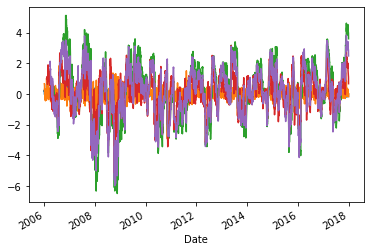

In [152]:
df_rolling = df.rolling(window=2).mean()
df_rolling_1 = df.rolling(window=4).mean()
df_rolling_2 = df.rolling(window=90).mean()
df_rolling_3 = df.rolling(window=30).mean()
df_rolling_4 = df.rolling(window=60).mean()

list_of_df = [df_rolling, df_rolling_1, df_rolling_2, df_rolling_3, df_rolling_4]

for i in list_of_df:
    if_df = (df - i).dropna()
    dickey(if_df)
    if_df.plot();



Looks like when we use a rolling mean of 2, our test statistic is very small (and is the smallest) which means we can reject the null and now assume our dataset is now stationary. 